# DBScan

### Importamos las librerias

In [3]:
# análisis
import pandas as pd
import geopandas as gpd
import numpy as np

# clustering
# from hdbscan import HDBSCAN # Codigo Original
from sklearn.cluster import DBSCAN # Codigo Modificado

# visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.colors import rgb2hex

# Esto configura la apariencia de los gráficos utilizando configuraciones de seaborn
sns.set(context='notebook', style='ticks', palette='inferno', font='Linux Biolinum O', font_scale=1.1)

# Esto es una instrucción de Jupyter que hace que los gráficos se desplieguen en el notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Datos: Encuesta Origen Destino de Viajes, Santiago 2012


/usr/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Fo

<Axes: >

findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Fo

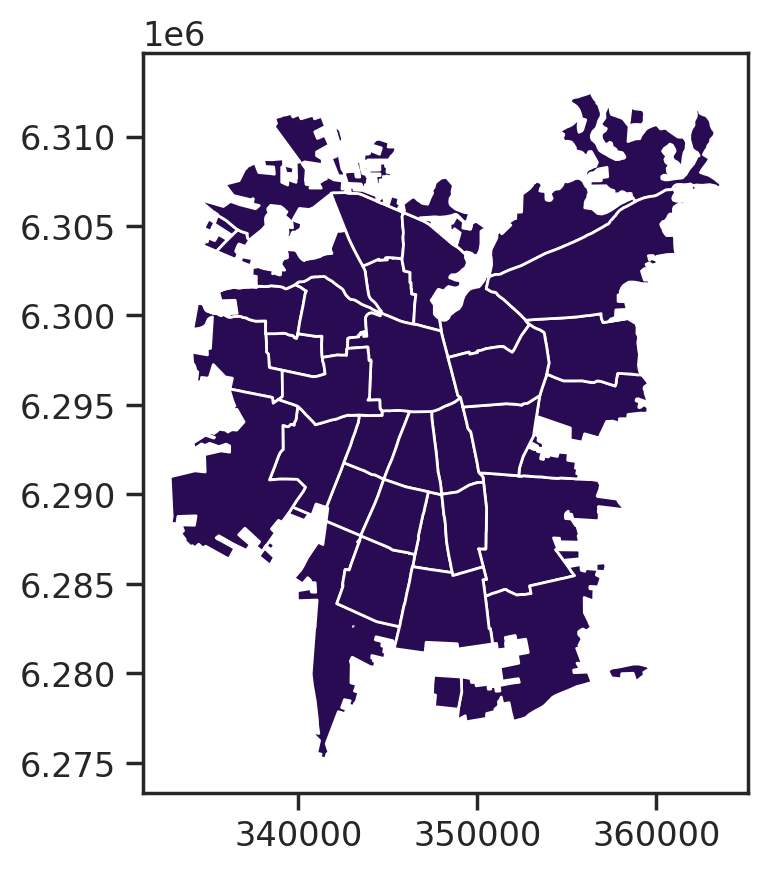

In [8]:
urban_areas = gpd.read_file('./data/urban_areas/', crs={'init': 'epsg:5361'})
municipalities = gpd.read_file('./data/shapefile_comunas/', crs={'init': 'epsg:5361'})
stgo_municipalities = gpd.sjoin(municipalities, urban_areas[urban_areas.NOMBRE == 'Santiago'], op='intersects')

def intersection(municipality, urban_area):
    return municipality.intersection(urban_area)

def urban_part(municipality):
    return intersection(municipality, urban_areas[urban_areas.NOMBRE == 'Santiago'].geometry.values[0])

stgo_urban_municipalities = (stgo_municipalities.copy()
                             .assign(geometry=lambda df_: df_['geometry'].map(urban_part))
                             .pipe(lambda x: x[~x.NOM_COM.isin(['Lampa', 'Colina'])]))

stgo_urban_municipalities.plot()

### Imprimos la tabla de datos

In [9]:
trips = pd.read_csv('./data/stgo-travel-survey-2012.csv.gz')
trips.sample(5)

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,Sector,Comuna,home_latitude,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona
71880,2775510303,277551,27755103,1,Vitacura,Vitacura,Oriente,Oriente,679,671,...,Oriente,VITACURA,-33.387217,-70.558065,5,2,0,0,1350334,671
11283,1349210101,134921,13492101,1,La Florida,La Florida,Sur-Oriente,Sur-Oriente,216,223,...,Sur-Oriente,LA FLORIDA,-33.526016,-70.579975,5,1,0,1,838639,216
70663,2729410101,272941,27294101,1,Santiago,Providencia,Centro,Oriente,50,511,...,Centro,SANTIAGO,-33.448822,-70.654823,3,1,0,0,875483,50
72494,2785110104,278511,27851101,1,Vitacura,Las Condes,Oriente,Oriente,679,295,...,Oriente,VITACURA,-33.390121,-70.560966,6,1,1,0,1040000,671
63602,2566010702,256601,25660107,1,San Bernardo,San Bernardo,Sur,Sur,776,780,...,Sur,SAN BERNARDO,-33.573137,-70.708884,7,0,2,2,875838,780


In [10]:
analysis_trips = trips[trips['Proposito'].isin(['Al trabajo', 'Al estudio'])].copy()
len(analysis_trips)

18966

In [11]:
X = analysis_trips[['DestinoCoordX', 'DestinoCoordY']].values
X.shape

(18966, 2)

In [139]:
dbscan = DBSCAN(eps=400, min_samples=100, n_jobs=-1)
analysis_trips['cluster'] = dbscan.fit_predict(X)
cluster_ids = analysis_trips['cluster'].value_counts()
len(cluster_ids) - 1

12

In [140]:
cluster_ids

-1     11810
 1      5491
 0       291
 2       197
 4       186
 3       148
 9       146
 7       132
 5       126
 8       121
 6       112
 11      103
 10      103
Name: cluster, dtype: int64

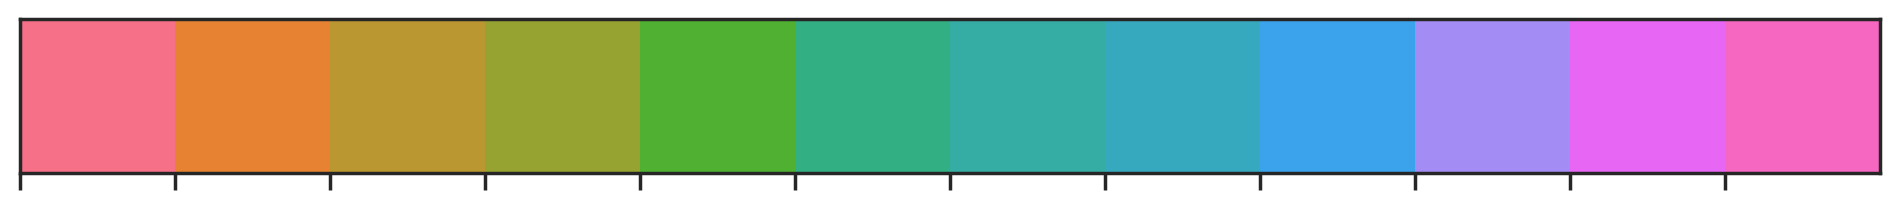

In [141]:
colors = sns.color_palette('husl', n_colors=len(cluster_ids) - 1)
sns.palplot(colors)

In [142]:
palette = dict(zip(range(len(cluster_ids) - 1), map(rgb2hex, colors)))
palette[-1] = '#afafaf'
palette

{0: '#f77189',
 1: '#e68332',
 2: '#bb9832',
 3: '#97a431',
 4: '#50b131',
 5: '#34af84',
 6: '#36ada4',
 7: '#38aabf',
 8: '#3ba3ec',
 9: '#a48cf4',
 10: '#e866f4',
 11: '#f668c2',
 -1: '#afafaf'}

### Conteo de cantidad de centros en la ciudad de Santiago

findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Font family 'Linux Biolinum O' not found.
findfont: Fo

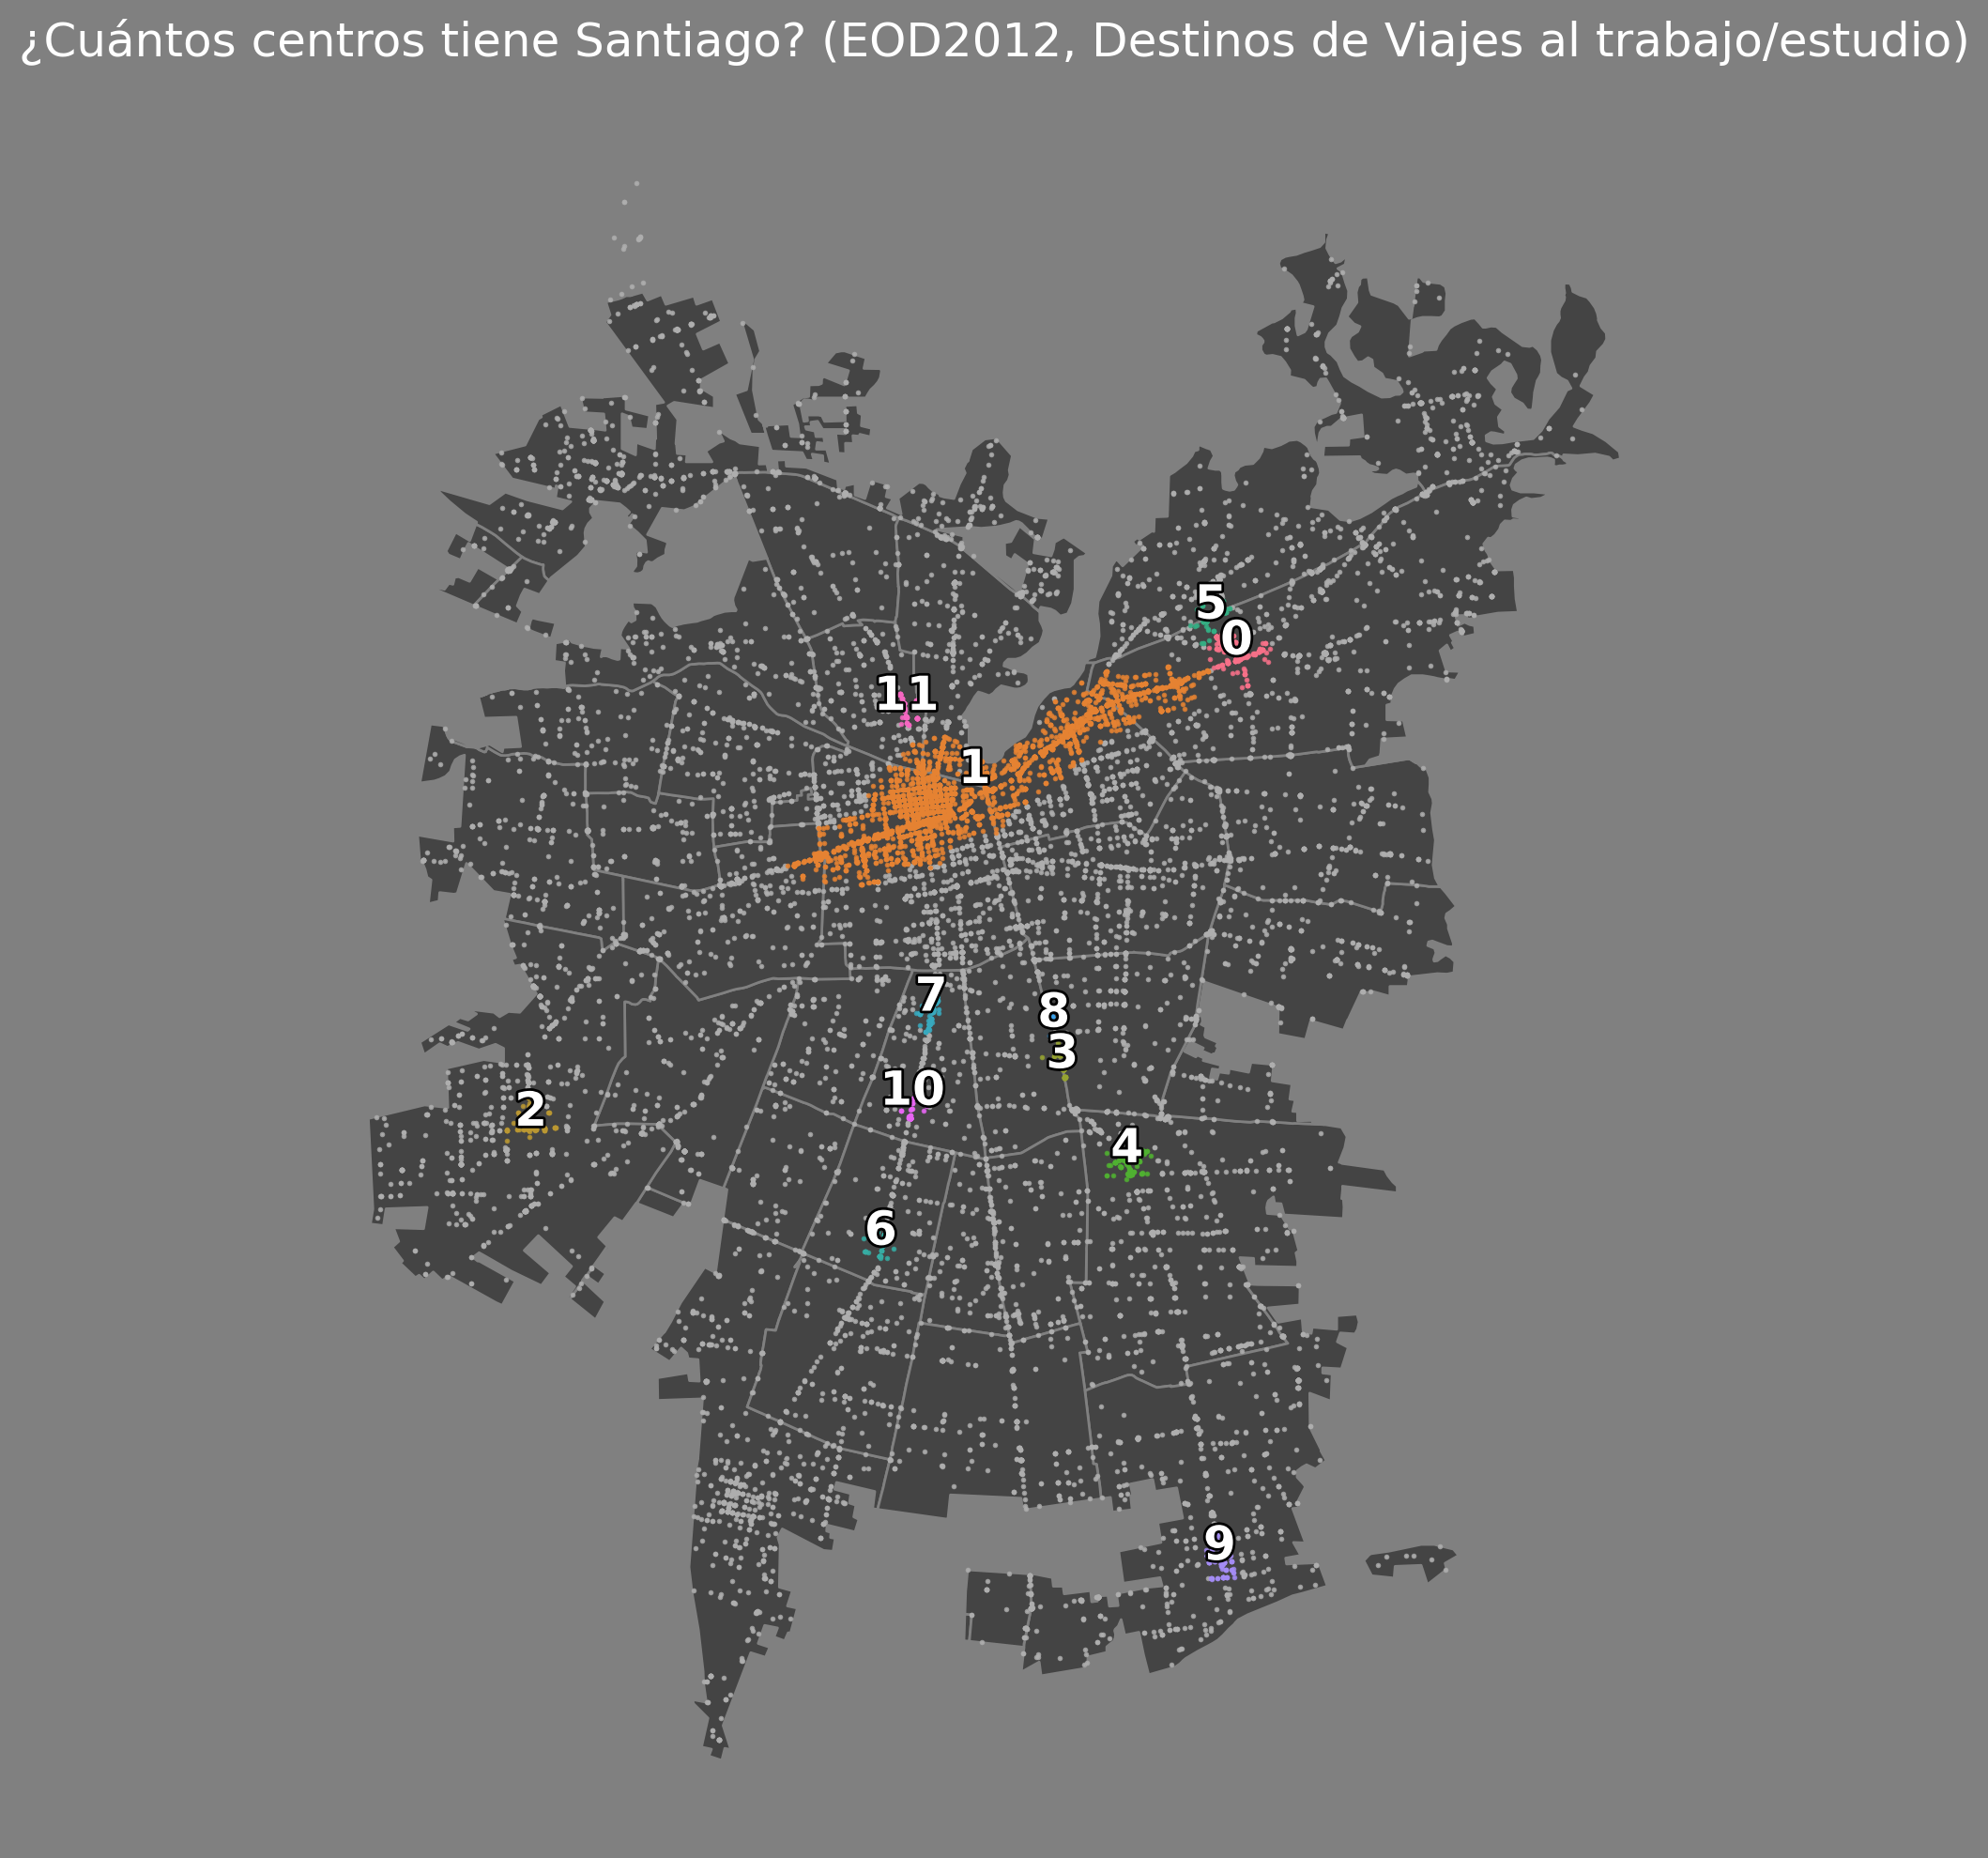

In [143]:
# creamos la figura
plt.figure(figsize=(12, 12), facecolor='grey')

# este método entrega el "eje" (axis) donde se grafica actualmente
ax = plt.gca()

# graficamos los bordes de las municipalidades en el eje
stgo_urban_municipalities.plot(ax=ax, edgecolor='grey', facecolor='#444444')

# pintamos los puntitos de cada cluster
for cluster_id in sorted(cluster_ids.index):
    # viajes correspondientes a cada cluster
    cluster_trips = analysis_trips[analysis_trips.cluster == cluster_id]
    
    # dibujamos directamente con matplotlib
    plt.plot(cluster_trips.DestinoCoordX, cluster_trips.DestinoCoordY, '.', alpha=0.8, markersize=2, color=palette[cluster_id])
    
    # para los clusters, agregamos la etiqueta correspondiente para poder identificarlos
    # pondremos la etiqueta en el promedio de las posiciones que tiene cada cluster
    if cluster_id >= 0:
        t = plt.text(cluster_trips.DestinoCoordX.mean(), cluster_trips.DestinoCoordY.mean(), str(cluster_id), 
                     horizontalalignment='center', fontsize=18, fontweight='bold', color='white')
        
        # éste es un efecto gráfico que facilita la comprensión del texto
        t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        
# configuraciones del gráfico:
# - radio de aspecto 1:1
plt.axis('equal')
# - título, no puede faltar!
plt.title('¿Cuántos centros tiene Santiago? (EOD2012, Destinos de Viajes al trabajo/estudio)', fontsize=18, color='white')
# - no dibujes las coordenadas, no las necesitamos. Aquí todes conocemos el contexto.
plt.axis('off');